In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data

from abtem import GridScan, PixelatedDetector, Potential, Probe, show_atoms, SMatrix, AnnularDetector
from abtem.reconstruct import epie
from ase.build import mx2
from abtem.structures import orthogonalize_cell
from abtem.measure import bandlimit

# Reconstruction of MoS2 using the ePIE algorithm

<AxesSubplot:title={'center':'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>

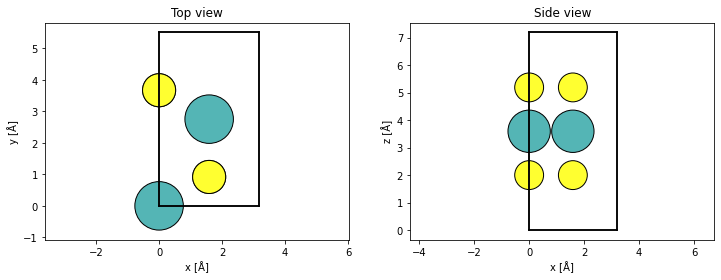

In [2]:
atoms = mx2(formula='MoS2', kind='2H', a=3.18, thickness=3.19, size=(1, 1, 1), vacuum=None)
atoms = orthogonalize_cell(atoms)
atoms.center(vacuum=2, axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')

In [3]:
potential = Potential(atoms, 
                      sampling=.05,
                      projection='infinite', 
                      slice_thickness=1, 
                      parametrization='kirkland').build()

potential = potential.tile((5,2))

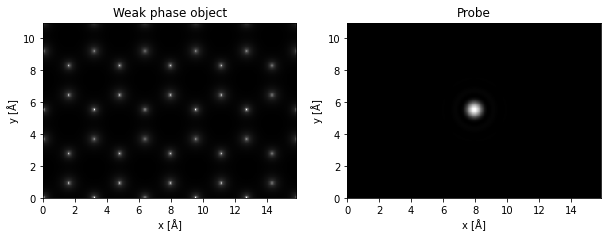

In [4]:
S = SMatrix(semiangle_cutoff=30, energy=80e3, expansion_cutoff=30, device='gpu')
S.grid.match(potential)

fig,(ax1,ax2)= plt.subplots(1,2, figsize=(10,5))
potential.project().show(ax=ax1, title='Weak phase object')
S.show(ax=ax2, title='Probe');

In [5]:
gridscan = GridScan((0,0), np.array(potential.extent), sampling=.2)
detector = PixelatedDetector()
measurements = S.scan(gridscan, [detector], potential)

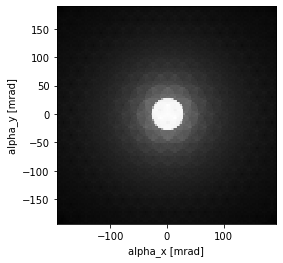

In [6]:
measurements[detector][0,0].show(power=.2);

In [7]:
probe_guess = S.equivalent_probe()

In [8]:
band_limited_measurment = bandlimit(measurements[detector], 80)

In [9]:
reconstructions = epie(band_limited_measurment, probe_guess, maxiter=3, return_iterations=True, fix_com=True)

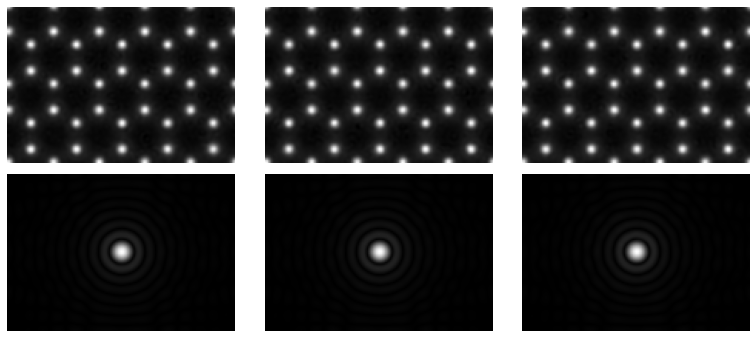

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(11,4.8))

for i in range(3):
    axes[0,i].imshow(np.angle(reconstructions[0][i].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions[1][i].array).T, origin='lower', cmap='gray')
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
    
plt.tight_layout()